In [ ]:
!pip install jaxopt
!pip install ott-jax
!pip install gpjax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## GP Jax preliminaries

In [ ]:
import jax
from jax.scipy.sparse.linalg import gmres
from jax.lax import custom_linear_solve
from jax.numpy.linalg import slogdet
import jax.numpy as jnp

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
import jax.random as jr
import gpjax as gpx
from functools import partial

In [ ]:
import seaborn as sns
# sns.set_context("notebook")
sns.set_context("paper")

## GP Sinkhorn

In [ ]:
def pad_point_clouds(data):
  # +1 for unified processing of all clouds including biggest one
  max_cloud_size = max([cloud.shape[0] for cloud in data]) + 1

  def pad_cloud(cloud):
    delta = max_cloud_size - cloud.shape[0]
    uniform = jnp.ones(cloud.shape[0]) / cloud.shape[0]
    zeros = jnp.zeros(delta)
    weights = jnp.concatenate([uniform, zeros], axis=0)
    cloud = jnp.pad(cloud, pad_width=((0, delta), (0,0)), mode='mean')
    return cloud, weights

  data = list(map(pad_cloud, data))
  coordinates = jnp.stack([t[0] for t in data])
  weights = jnp.stack([t[1] for t in data])
  return coordinates, weights

In [ ]:
from typing import Any, Optional
from dataclasses import dataclass

from jaxopt.tree_util import tree_l2_norm

from ott.geometry import pointcloud
import ott.core.sinkhorn as sinkhorn

from jaxopt import LBFGS


def mu_cloud_embedding(cloud, mu, 
                       init_dual=(None, None),
                       **kwargs):
  init_dual_cloud, init_dual_mu = init_dual  # for warm start

  coordinates, weights = cloud  # unpack distribution
  mu_cloud, mu_weight = mu  # unpack distribution

  sinkhorn_epsilon = kwargs.pop('sinkhorn_epsilon')

  mean_clouds = jnp.sum(coordinates * weights[:,:,jnp.newaxis], axis=1)
  mean_clouds = jnp.mean(mean_clouds, axis=0, keepdims=True)
  scale = 1.

  def sinkhorn_single_cloud(cloud_coords, cloud_weight,
                            init_dual_cloud, init_dual_mu):
    # weight projection
    mu_w = jax.nn.softmax(mu_weight) if mu_weight is not None else None

    # points projection
    # invariance by translation : recenter mu around its mean
    mu_c = mu_cloud - jnp.mean(mu_cloud, axis=0, keepdims=True)
    mu_c = scale * jnp.tanh(mu_c)
    mu_c = mu_c + mean_clouds  # re-center toward clouds of the trainset

    geom = pointcloud.PointCloud(cloud_coords, mu_c,
                                 epsilon=sinkhorn_epsilon)
    out = sinkhorn.sinkhorn(geom, cloud_weight, mu_w,
                            init_dual_a=init_dual_cloud,
                            init_dual_b=init_dual_mu,
                            **kwargs)
    return out

  parallel_sinkhorn = jax.vmap(sinkhorn_single_cloud,
                               in_axes=(0, 0, 0, 0),
                               out_axes=0)
  
  outs = parallel_sinkhorn(coordinates, weights, init_dual_cloud, init_dual_mu)
  init_dual = outs.f, outs.g  # for warm start
  return outs.g, init_dual

In [ ]:
def mean_cloud_embedding(cloud, mu_params, init_dual, **kwargs):
  del init_dual  # unused
  coordinates, weights = cloud
  mu_cloud, _ = mu_params
  mean_cloud = jnp.sum(coordinates * weights[:,:,jnp.newaxis], axis=1, keepdims=True)
  pairwise_dist = jnp.sum((mean_cloud - mu_cloud[jnp.newaxis,:,:])**2, axis=-1)
  return pairwise_dist, None

In [ ]:
def mu_2d_toy(sample_train):
  mu_cloud = jnp.array([[0.25, 0.5], [0.75, 0.5], [0.5, 0.25], [0.5, 0.75], [0.5, 0.5]])
  mu_weight = None
  return mu_cloud, mu_weight

In [ ]:
def mu_uniform_ball(sample_train, key, mu_size, radius=0.5, with_weight=False):
  dim = sample_train[0].shape[-1]
  key_theta, key_r = jax.random.split(key)
  mu_cloud = jax.random.normal(key_theta, shape=(mu_size, dim))
  norms = jnp.sqrt(jnp.sum(mu_cloud**2, axis=1, keepdims=True))
  mu_cloud = mu_cloud / norms
  radii = jax.random.uniform(key_r, shape=(mu_size, 1))
  mu_cloud = mu_cloud * radius * radii
  centroids = jnp.mean(sample_train[0], axis=1)
  centroids_center = jnp.mean(centroids, axis=0, keepdims=True)
  mu_cloud = mu_cloud + centroids_center  # OT is invariant by translation
  mu_weight = None
  if with_weight:
    mu_weight = jnp.zeros(len(mu_cloud))
  return mu_cloud, mu_weight

In [ ]:
def mu_uniform_sphere(sample_train, key, mu_size, radius=0.5, with_weight=False):
  dim = sample_train[0].shape[-1]
  key_theta, key_r = jax.random.split(key)
  mu_cloud = jax.random.normal(key_theta, shape=(mu_size, dim))
  norms = jnp.sqrt(jnp.sum(mu_cloud**2, axis=1, keepdims=True))
  mu_cloud = mu_cloud / norms
  mu_cloud = mu_cloud * radius
  centroids = jnp.mean(sample_train[0], axis=1)
  centroids_center = jnp.mean(centroids, axis=0, keepdims=True)
  mu_cloud = mu_cloud + centroids_center  # OT is invariant by translation
  mu_weight = None
  if with_weight:
    mu_weight = jnp.zeros(len(mu_cloud))
  return mu_cloud, mu_weight

## Dataset

In [ ]:
import numpy as onp
import jax
import jax.numpy as jnp

def targets_ground_truth(points, sigmas):
  m1, m2 = points[:,0], points[:,1]
  targets = (m1 - m2**2) / (1 + jnp.squeeze(sigmas))
  targets = targets.reshape((-1,1))
  return targets

def generate_meta_dataset(key, ds_size, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  min_sigma, max_sigma = sigmas_bounds
  means = jax.random.uniform(key_1, shape=(ds_size, 2), minval=0.2, maxval=0.8)
  sigmas = jax.random.uniform(key_2, shape=(ds_size, 1), minval=min_sigma, maxval=max_sigma)
  targets = targets_ground_truth(means, sigmas)
  return targets, (means, sigmas)

def generate_sample_dataset(key, ds_size, num_points, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  targets, (means, sigmas) = generate_meta_dataset(key_1, ds_size, sigmas_bounds)
  sample = means[:,jnp.newaxis,:] + jax.random.normal(key_2, shape=(ds_size, num_points, 2)) * sigmas[:,jnp.newaxis,:]
  sample = sample - jnp.mean(sample, axis=[0, 1], keepdims=True)
  return sample, targets

In [ ]:
key = jax.random.PRNGKey(974)
ds_size = 100
num_points = 30
min_sigma = 0.01
max_sigma = 0.02 
sample_ds, target_ds = generate_sample_dataset(key, ds_size, num_points, (min_sigma, max_sigma))

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.5
sample_train, sample_test, y_train, y_test = train_test_split(sample_ds, target_ds, test_size=test_size, shuffle=True, random_state=89)
sample_train = pad_point_clouds(sample_train)
sample_test = pad_point_clouds(sample_test)

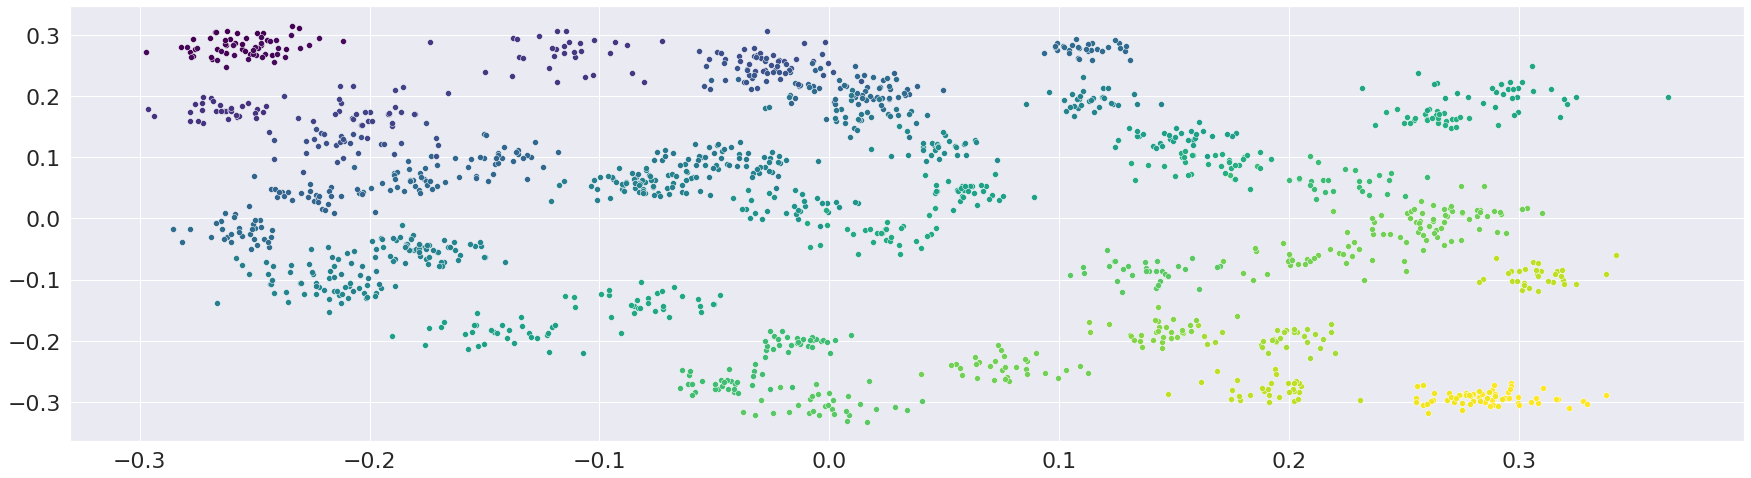

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pprint import PrettyPrinter
import seaborn as sns

pp = PrettyPrinter(indent=4)

def plot_ds(sample_train_coords, y_train, ax):
  min_sample, max_sample = y_train.min(), y_train.max()
  for sample, target in zip(sample_train_coords, y_train):
    r = (target - min_sample) / (max_sample - min_sample)
    color = cm.viridis(r)
    s = jnp.exp(target) / 20
    sns.scatterplot(x=sample[:,0], y=sample[:,1], color=color, ax=ax)
plot_ds(sample_train[0], y_train, ax=None)

In [ ]:
import pandas as pd

def plot_mu_points(mu_points, ax):
  mu_points = onp.array(mu_points)
  T = mu_points.shape[0]
  num_pts = mu_points.shape[1]
  points = list(map(str, range(1, num_pts+1)))*T
  timesteps = onp.array([(i//num_pts) for i in range(T * num_pts)])
  mu_points = mu_points - jnp.mean(mu_points, axis=1, keepdims=True)  # invariant by translation
  scale = 1.
  mu_points = scale * jnp.tanh(mu_points)
  mu_points = mu_points.reshape((-1, 2))
  x_coord = mu_points[:,0]
  y_coord = mu_points[:,1]
  df = pd.DataFrame({'x':x_coord, 'y':y_coord, 'points':points, 'timesteps':timesteps})
  sns.lineplot(data=df, x='x', y='y', hue='points', markers='x', sort=False, marker='o', linestyle='-', ax=ax)
  ax.set_title('$\mu$ coordinates')

def plot_loss(losses, ax):
  timesteps = onp.arange(len(losses))
  sns.lineplot(x=timesteps, y=losses, ax=ax)
  ax.set_xlabel('Timesteps')
  ax.set_ylabel('Loss')
  ax.set_title('Negative Log Marginal Likelihood')

def plot_mu_weights(mu_weights, ax):
  if mu_weights is None:
    return None
  mu_weights = onp.array(mu_weights)
  T = mu_weights.shape[0]
  num_pts = mu_weights.shape[1]
  points = list(map(str, range(1, num_pts+1)))*T
  timesteps = onp.array([(i//num_pts) for i in range(T * num_pts)])
  mu_weights = jax.nn.softmax(mu_weights, axis=-1)
  mu_weights = mu_weights.flatten()
  df = pd.DataFrame({'timesteps':timesteps, 'points':points, '$\mu$ weights':mu_weights})
  sns.lineplot(data=df, x='timesteps', y='$\mu$ weights', hue='points', markers='x', sort=False, marker='o', linestyle='-', ax=ax)
  ax.set_xlabel('Timesteps')
  ax.set_ylabel('$\mu$ weights')
  ax.set_title('$\mu$ weights')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

def evaluate(cloud_embedding_fn, kernel_params, mu_params,
             posterior, likelihood, constrainer, unconstrainer,
             sample_train, sample_test, y_train, y_test):
  X_train, _ = cloud_embedding_fn(sample_train, mu_params)
  X_test, _ = cloud_embedding_fn(sample_test, mu_params)
  D = gpx.Dataset(X=X_train, y=y_train)
  posterior_fn = posterior(D, kernel_params)

  latent_dist = posterior_fn(X_test)
  predictive_dist = likelihood(latent_dist, kernel_params)
  predictive_mean = predictive_dist.mean()
  predictive_std = predictive_dist.stddev()

  try:
    evs = explained_variance_score(y_test, predictive_mean)
    rmse = mean_squared_error(y_test, predictive_mean, squared=False)
    mae = mean_absolute_error(y_test, predictive_mean)
  except Exception as e:
    evs = float('nan')
    rmse = float('nan')
    mae = float('nan')
  
  log_likelihood = posterior.marginal_log_likelihood(D, constrainer)(gpx.transform(kernel_params, unconstrainer))
  msg = f"[GPJAX] TrainSetSize={len(X_train)} mae={mae:.5f} rmse={rmse:.5f} evs={evs:.5f} log-likelihood={log_likelihood:.3f}"
  print(msg)
  return evs, rmse, mae, log_likelihood

In [ ]:
from tqdm import tqdm

def prettify_mu_str(mu):
  max_len = 12
  mu_selected = mu[0][:max_len]
  return "[" + ", ".join([f"({mu_p[0]:.3f},{mu_p[1]:.3f})" for mu_p in mu_selected]) + "]"

def learn(opt, opt_update, loss_fn,
          init_mu, cloud_embedding_fn,
          posterior, likelihood, constrainer, unconstrainer,
          sample_train, sample_test,
          y_train, y_test,
          verbose=False):
  ## init GP params
  parameter_state = gpx.initialise(posterior, key=None)
  constrained_kernel_params, _, _, _ = parameter_state.unpack()
  kernel_params = gpx.transform(constrained_kernel_params, unconstrainer)

  if verbose:
    print('Unconstrained params:', end='');
    pp.pprint(constrained_kernel_params)
    print('Constrained params:', end='');
    pp.pprint(kernel_params)

  ## init Mu Sinkhorn
  mu_params = init_mu(sample_train)

  if verbose:
    print("μ: " + prettify_mu_str(mu_params))

  ## Parameters to be optimized by LBFGS
  params = {'kernel_params':kernel_params, 'mu_params':mu_params}

  ## precomputation for speed-up
  init_dual = cloud_embedding_fn(sample_train, mu_params)[1]

  opt_state = opt.init_state(params, init_dual=init_dual)
  mu_hist = [params['mu_params'][0]], [params['mu_params'][1]]
  losses = [float(loss_fn(params, init_dual)[0])]
  log_rate = 1
  pb = tqdm(range(opt.maxiter))
  for step in range(opt.maxiter):
    params, opt_state = opt_update(params, opt_state, init_dual)
    init_dual = opt_state.aux
    loss_val = opt_state.value
    mu_hist[0].append(params['mu_params'][0])
    mu_hist[1].append(params['mu_params'][1])
    losses.append(float(loss_val))
    if step % log_rate == 0:
      pb.update(log_rate)
      mu_str = prettify_mu_str(params['mu_params'])
      pb.set_postfix({"Objective": f"{loss_val: .2f}", "μ":mu_str})
  pb.close()
  print('')

  kernel_params = params['kernel_params']
  mu_params = params['mu_params']
  kernel_params = gpx.transform(kernel_params, constrainer)
  pp.pprint(kernel_params)

  test_metrics = evaluate(cloud_embedding_fn, kernel_params, mu_params,
           posterior, likelihood, constrainer, unconstrainer,
           sample_train, sample_test, y_train, y_test)

  return kernel_params, mu_params, (mu_hist, losses, test_metrics)

In [ ]:
def run_experiment(mu_sizes, seeds, sample_train, sample_test, y_train, y_test, *,
                   with_weight):
  f, axes = plt.subplots(nrows=len(mu_sizes), ncols=3)
  axes = axes.reshape((len(mu_sizes), 3))

  kernel = gpx.RBF()
  prior = gpx.Prior(kernel=kernel)
  likelihood = gpx.Gaussian(num_datapoints=len(sample_train[0]))
  posterior = prior * likelihood

  parameter_state = gpx.initialise(posterior, key=None)
  _, trainable, constrainer, unconstrainer = parameter_state.unpack()

  kwargs = dict(
      sinkhorn_epsilon               = 1e-1 ,
      lse_mode                       = True ,
      implicit_differentiation       = False,
      implicit_solver_ridge_kernel   = 1e-2 ,  # promote zero sum solutions
      implicit_solver_ridge_identity = 1e-2 ,  # regul for ill-posed problem
  )

  cloud_embedding_fn = partial(mu_cloud_embedding, **kwargs)

  def loss_fn(params, init_dual):
    kernel_params = params['kernel_params']
    mu_params = params['mu_params']
    X_train, init_dual = cloud_embedding_fn(sample_train, mu_params, init_dual)
    kernel_params = gpx.parameters.trainable_params(kernel_params, trainable)
    D = gpx.Dataset(X=X_train, y=y_train)
    nll = posterior.marginal_log_likelihood(D, constrainer, negative=True)
    return nll(kernel_params), init_dual

  opt = LBFGS(fun=loss_fn, maxiter=30, tol=1e-3, maxls=20, has_aux=True)

  @jax.jit
  def opt_update(params, opt_state, init_dual):
    return opt.update(params, opt_state, init_dual=init_dual)

  df_stats = []

  for mu_size, ax in zip(mu_sizes, axes):

    print( "##########################################")
    print(f"########### |μ|={mu_size:9d} ################")
    print( "##########################################")

    test_metrics_avg = []
    for i, seed in enumerate(seeds):

      key = jax.random.PRNGKey(seed)
      init_mu = partial(mu_uniform_sphere, key=key,
                        mu_size=mu_size, with_weight=with_weight)

      kernel_params, mu_params, metrics = learn(opt, opt_update, loss_fn,
            init_mu, cloud_embedding_fn,
            posterior, likelihood, constrainer, unconstrainer,
            sample_train, sample_test,
            y_train, y_test)
      
      mu_hist, losses, test_metrics = metrics
      test_metrics_avg.append(test_metrics)

      if i+1 == len(seeds):
        plot_ds(sample_train[0], y_train, ax[0])
        plot_mu_points(mu_hist[0], ax[0])
        ax[0].axis('equal')
        plot_mu_weights(mu_hist[1], ax[1])
        plot_loss(losses, ax[2])
        
    test_metrics_avg = onp.array(test_metrics_avg)
    df = pd.DataFrame(data=test_metrics_avg, columns=['evs', 'rmse', 'mae', 'log_likelihood'])
    df['mu_size'] = mu_size
    df_stats.append(df)

  df_stats = pd.concat(df_stats, axis=0)
  return kernel_params, mu_params, df_stats, metrics

/usr/local/lib/python3.7/dist-packages/gpjax/parameters.py:40: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  warn("No PRNGKey specified. Defaulting to seed 123.")


##########################################
########### |μ|=        6 ################
##########################################


100%|██████████| 30/30 [01:35<00:00,  3.17s/it, Objective=-167.11, μ=[(0.715,0.628), (0.546,1.108), (-2.304,0.234), (0.556,0.385), (0.552,-0.893), (0.549,-0.782)]]



{   'kernel': {   'lengthscale': DeviceArray([3.7617252], dtype=float64),
                  'variance': DeviceArray([0.82003499], dtype=float64)},
    'likelihood': {'obs_noise': DeviceArray([1.96100078e-05], dtype=float64)},
    'mean_function': {}}
[GPJAX] TrainSetSize=50 mae=0.02571 rmse=0.02898 evs=0.99693 log-likelihood=167.120


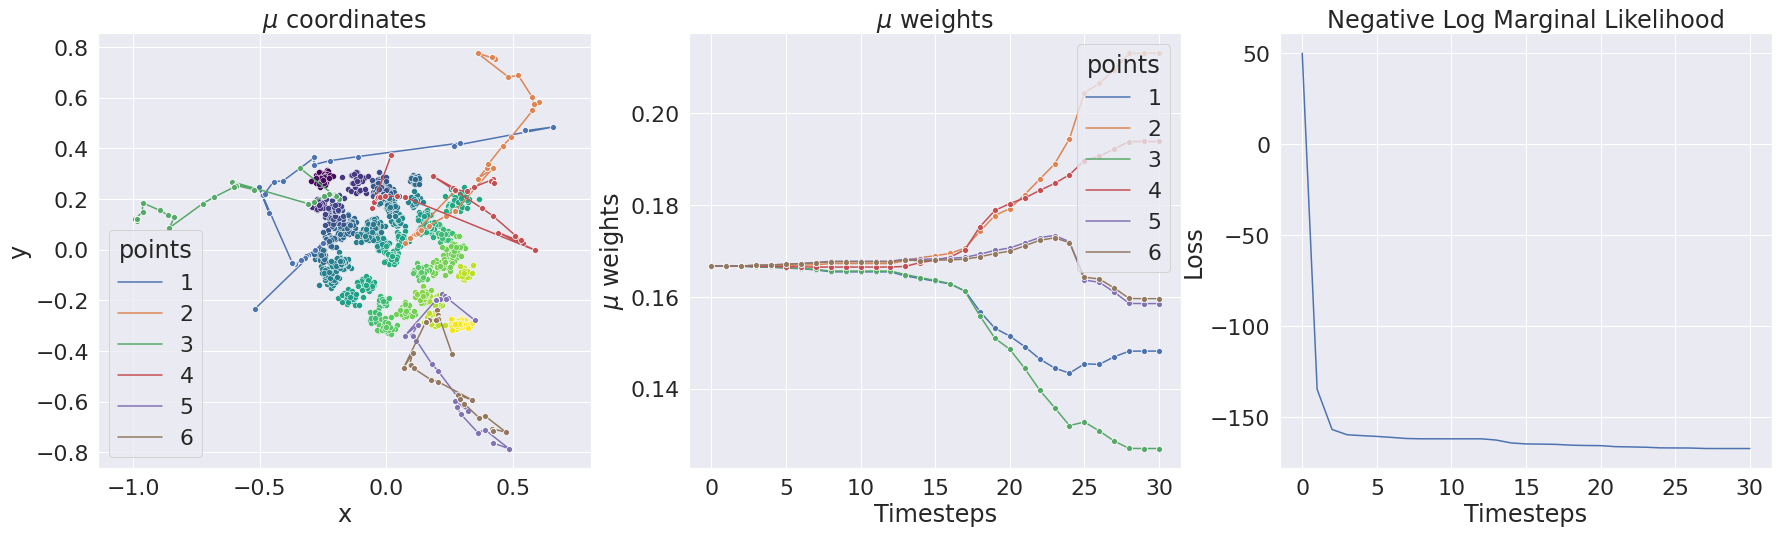

In [ ]:
mu_sizes = [6]  # [1, 2, 3, 4, 5, 7, 10, 15, 20]
seeds = [573]  #, 11, 55, 79, 46, 98, 73, 22, 34, 76]

plt.rcParams["figure.figsize"] = (24+6, 8*len(mu_sizes))
sns.set(font_scale=2)

kernel_params, mu_params, df_stats, metrics = run_experiment(mu_sizes, seeds, sample_train, sample_test, y_train, y_test, with_weight=True)

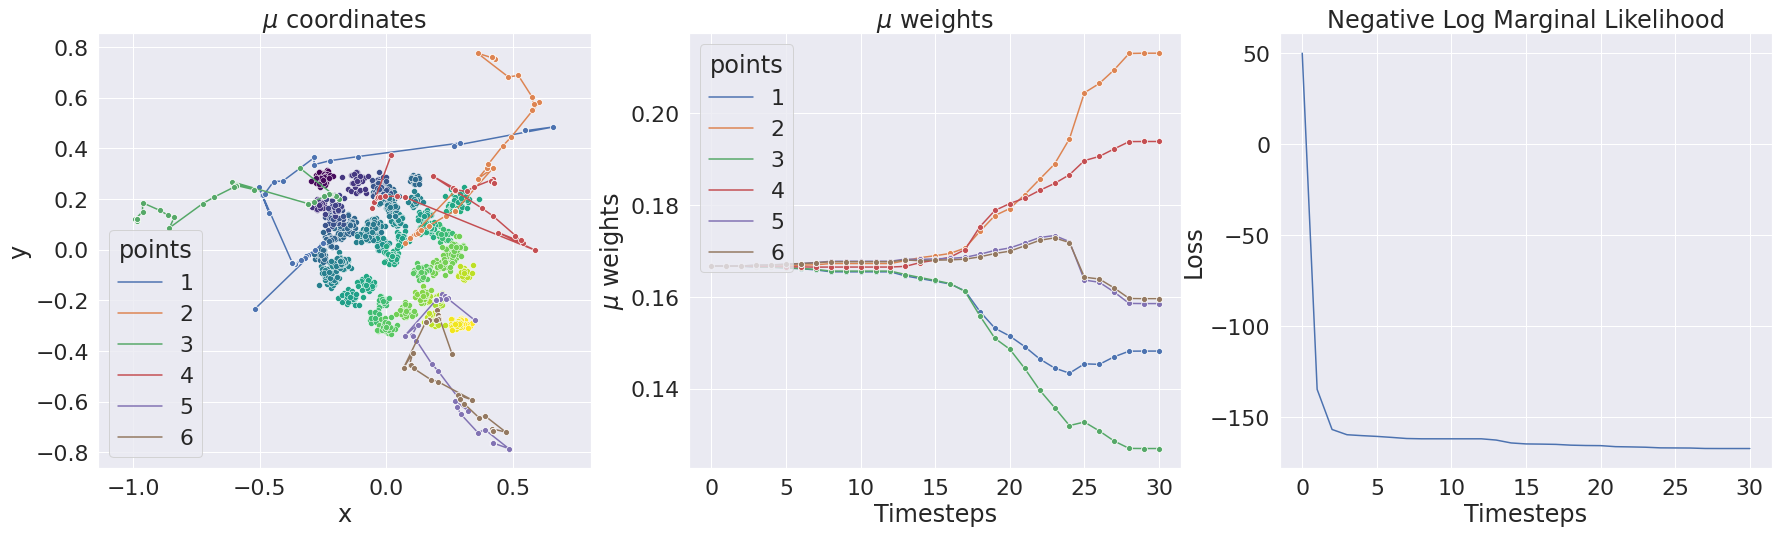

In [ ]:
plt.rcParams["figure.figsize"] = (24+6, 8*len(mu_sizes))
sns.set(font_scale=2)
ncols = 3
f, axes = plt.subplots(nrows=1, ncols=ncols)
axes = onp.array(axes).reshape((1, ncols))
mu_hist, losses, test_metrics = metrics
for ax in axes:
  plot_ds(sample_train[0], y_train, ax[0])
  plot_mu_points(mu_hist[0], ax[0])
  ax[0].axis('equal')
  plot_mu_weights(mu_hist[1], ax[1])
  sns.move_legend(ax[1], "upper left")
  plot_loss(losses, ax[2])

In [ ]:
def save_mu(mu_hist, losses):
  mu_points, mu_weights = mu_hist
  mu_points = onp.array(mu_points)
  mu_weights = onp.array(mu_weights)

  T = mu_weights.shape[0]
  num_pts = mu_weights.shape[1]

  points = list(map(str, range(1, num_pts+1)))*T
  timesteps = onp.array([(i//num_pts) for i in range(T * num_pts)])

  mu_weights = jax.nn.softmax(mu_weights, axis=-1)
  mu_weights = mu_weights.flatten()
  
  # invariant by translation
  mu_points = mu_points - jnp.mean(mu_points, axis=1, keepdims=True)  
  scale = 1.
  mu_points = scale * jnp.tanh(mu_points)
  mu_points = mu_points.reshape((-1, 2))
  x_coord = mu_points[:,0]
  y_coord = mu_points[:,1]

  losses = onp.array([[v]*num_pts for v in losses]).flatten()

  df = pd.DataFrame({'timesteps':timesteps, 'points':points,
                     '$\mu$ weights':mu_weights,
                     'x':x_coord, 'y':y_coord,
                     'losses':losses})
  df.to_csv('toy_metric.csv')


def save_metrics(metrics):
  mu_hist, losses, test_metrics = metrics
  save_mu(mu_hist, losses)
  test_metrics = onp.array([test_metrics])
  test_metrics = pd.DataFrame(data=test_metrics, columns=['evs', 'rmse', 'mae', 'log_likelihood'])
  test_metrics.to_csv('toy_score.csv')

In [ ]:
save_metrics(metrics)